# Boosting

*Boosting* refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are [*Adaboost*](https://en.wikipedia.org/wiki/AdaBoost)(short for *Adaptive Boosting*) and [*Gradient Boosting*](https://en.wikipedia.org/wiki/Gradient_boosting).

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='darkgrid', palette='icefire')

# Seaborn generates a lot of warnings. Disable them.
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [2]:
# Plot properties.
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.titlesize'] = 20

## Adaboost

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the harder cases. This is the technique used by *Adaboost*.

For example, to build an *Adaboost classifier*, a first base classifier (such as *DecisionTreeClassifier*) is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on.

<img src='../data/adaboost.png'> </img>

**Note:** There is one important drawback to this sequential learning technique: *it cannot be parallelized*, since each predictor can only be trained after the previous predictors has been trained and evaluated. As a result, *Adaboost* does not scale as well as bagging.

## Intuition

Let's take a closer look at the *Adaboost* algorithm. Each instance weight $w_i$ is initially set to $\frac{1}{n}$, where $n$ is the number of data samples. A first predictor is trained and its weighted error rate $\epsilon_i$, is computed on the trained set.

<font size="5">
$$
\epsilon_j = \frac{\underset{i, \hat{y}_{ij} \neq y_j}\sum w_i}{\underset{i}\sum w_i}
$$
</font>

where $\hat{y}_{ij}$ is the $j^{th}$ predictor's response to $x_i$ and $y_i$ is the ground truth label for $x_i$.

The predictor's weight $\alpha_j$ is then computed as 

$$\alpha_j = \eta \; log \left( \frac{1-\epsilon_j}{\epsilon_j} \right)$$

where $\eta$ is the learning rate parameter. The more accuraet the predictor is, the higher its weight will be (see plot below). However, if its most often wrong (or less accurate than random guessing), then its weight will be negative.

Text(0, 0.5, 'Alpha')

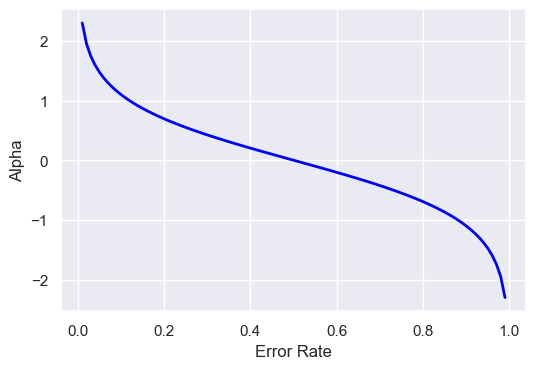

In [3]:
# learning rate 
eta = 0.5

x = np.linspace(0.01,0.99,100).astype(float)
y = eta * np.log((1.-x) / x)
plt.plot(x,y,'b-')
plt.xlabel('Error Rate')
plt.ylabel('Alpha')

Next, the instance weights are updated as follows:

$$
w_i = \begin{cases}
w_i, & \text{if } \; \; \hat{y}_{ij} = y_i \\
w_i e^{\alpha_j}, & \text{if } \; \; \hat{y}_{ij} \neq y_i
\end{cases}
$$

Then all the instance weights are normalized, (divided by $\underset{i} \sum w_i$).

Finally, a new predictor is trained using the updated weights, and the whole process is repeated. The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found ($\epsilon_j = 0$).

To make predictions, *Adaboost* simply computes the predictions of all the predictors and weighs them using the predictor weights $\alpha_j$. The predicted class is the one that receives the majority of weighted votes.

$$
\hat{y}(x) = \textrm{argmax }_k \underset{\hat{y}_j(x) = k}\sum \alpha_j
$$

## `AdaBoostClassifier` with Iris

In [4]:
# Load data
iris = load_iris()

In [5]:
# Lets look at the dataframe.
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [6]:
# Use features petal length and width ONLY.
X = iris.data[:, 2:]
y = iris.target

In [7]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

print('No. of train samples: {}'.format(len(X_train)))
print('No. of test samples: {}'.format(len(X_test)))

No. of train samples: 105
No. of test samples: 45


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

tree_clf = DecisionTreeClassifier(max_depth=1, random_state=42)

ada_clf = AdaBoostClassifier(base_estimator=tree_clf,
                             n_estimators=10,
                             learning_rate=0.01,
                             random_state = 42)

ada_clf.fit(X_train,y_train)

/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
          learning_rate=0.01, n_estimators=10, random_state=42)

In [10]:
y_pred = ada_clf.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score

print(f'Test accuracy: {accuracy_score(y_test, y_pred)}')

Test accuracy: 1.0


**If the *Adaboost* ensemble is over-fitting the training set, you can try reducing the number of estimators or more strongly regularize the base estimator.**

## `AdaBoostClassifier` on Churn Dataset

In [12]:
churn = pd.read_csv('../data/Churn.csv')
churn.describe()

,AccountLength,AreaCode,IntlPlan,VMailPlan,VMailMessage,DayMins,DayCalls,DayCharge,EveMins,EveCalls,EveCharge,NightMins,NightCalls,NightCharge,IntlMins,IntlCalls,IntlCharge,CusServCalls,Churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,0.096910,0.276628,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914
std,39.822106,42.371290,0.295879,0.447398,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,101.000000,415.000000,0.000000,0.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,510.000000,0.000000,1.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000
max,243.000000,510.000000,1.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


In [13]:
# missing values
churn.isnull().sum()

State            0
AccountLength    0
AreaCode         0
Phone            0
IntlPlan         0
VMailPlan        0
VMailMessage     0
DayMins          0
DayCalls         0
DayCharge        0
EveMins          0
EveCalls         0
EveCharge        0
NightMins        0
NightCalls       0
NightCharge      0
IntlMins         0
IntlCalls        0
IntlCharge       0
CusServCalls     0
Churn            0
dtype: int64

In [14]:
# split the file into Independent and dependent variables
churnY = churn.iloc[::,20]
print(churnY.describe())
churnX = churn
churnX.drop(columns=['Churn','Phone'],axis=1,inplace=True)
print(churnX.shape)

count    3333.000000
mean        0.144914
std         0.352067
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Churn, dtype: float64
(3333, 19)


In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(churnX, churnY,
                                                    test_size = 0.30,
                                                    random_state = 42)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2333, 19)
(2333,)
(1000, 19)
(1000,)


In [16]:
# lable encoding for strings - state
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_train.State = le.fit_transform(X_train.State)
X_test.State = le.transform(X_test.State)
print(X_train.State.describe())

count    2333.000000
mean       26.104158
std        14.880249
min         0.000000
25%        14.000000
50%        26.000000
75%        39.000000
max        50.000000
Name: State, dtype: float64


In [17]:
# apply one hot encoding on state and area
from sklearn.preprocessing import OneHotEncoder
categories = np.array([17,18])                 # column 17 - state, 18 - area code
OHE = OneHotEncoder(n_values = 'auto', categorical_features = categories, 
                    sparse = False, handle_unknown = 'ignore')
X_train = OHE.fit_transform(X_train)
print(X_train.shape)
X_test = OHE.transform(X_test)
print(X_test.shape)

(2333, 33)
(1000, 33)


In [18]:
tree_clf = DecisionTreeClassifier(max_depth=2, class_weight='balanced', random_state=42)

ada_clf = AdaBoostClassifier(base_estimator=tree_clf,
                             n_estimators=200,
                             learning_rate=0.5,
                             random_state = 42)

ada_clf.fit(X_train,Y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

In [19]:
Y_pred = ada_clf.predict(X_test)

In [20]:
from sklearn.metrics import accuracy_score

print(f'Test accuracy: {accuracy_score(Y_test, Y_pred)}')

Test accuracy: 0.918


Compare this with a `DecisionTreeClassifier` of `max_depth=5`.

In [21]:
tree2_clf = DecisionTreeClassifier(max_depth=5, 
                                   splitter='best', 
                                   class_weight='balanced',
                                   random_state=42)

tree2_clf.fit(X_train, Y_train)
Y_pred = tree2_clf.predict(X_test)

print(f'Test accuracy: {accuracy_score(Y_test, Y_pred)}')

Test accuracy: 0.911


Notice, that the test accuracy improves with `AdaBoostClassifier` than even a deeper *DecisionTreeClassifier*.

In [22]:
predictProb = ada_clf.predict_proba(X_test)
print(predictProb[0:10])
PProb = pd.DataFrame(predictProb)

[[0.51491232 0.48508768]
 [0.53359181 0.46640819]
 [0.49534998 0.50465002]
 [0.5165116  0.4834884 ]
 [0.52212842 0.47787158]
 [0.51743587 0.48256413]
 [0.53100037 0.46899963]
 [0.53051039 0.46948961]
 [0.51933125 0.48066875]
 [0.50875532 0.49124468]]


In [23]:
# %%time

from sklearn.model_selection import GridSearchCV

# build grid search parameters
params = {'n_estimators': [100, 200],
         'learning_rate': [0.01, 0.5]}

CV = GridSearchCV(estimator=AdaBoostClassifier(base_estimator=None), 
                  param_grid=params, 
                  scoring = 'roc_auc', cv=2, n_jobs=-1, verbose=10)

CV.fit(X_train,Y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV] learning_rate=0.5, n_estimators=100 .............................
[CV] learning_rate=0.5, n_estimators=100 .............................
[CV] learning_rate=0.5, n_estimators=200 .............................
[CV] learning_rate=0.5, n_estimators=200 .............................
[CV]  learning_rate=0.01, n_estimators=100, score=0.7486813381320432, total=   0.4s
[CV]  learning_rate=0.01, n_estimators=100, score=0.6957654145995747, total=   0.4s
[CV]  learning_rate=0.5, n_estimators=100, score=0.8114638031742287, total=   0.4s
[CV]  learning_rate=0.5, n_estimators=100, score=0.7972537207654148, total=   0.4s


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s


[CV]  learning_rate=0.01, n_estimators=200, score=0.7938727948551537, total=   0.8s
[CV]  learning_rate=0.01, n_estimators=200, score=0.7322289156626507, total=   0.8s
[CV]  learning_rate=0.5, n_estimators=200, score=0.8059413534721813, total=   0.7s
[CV]  learning_rate=0.5, n_estimators=200, score=0.7769489723600285, total=   0.7s


[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.9s finished


GridSearchCV(cv=2, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200], 'learning_rate': [0.01, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [24]:
# Preidct on Test data and check the confusion matrix
predictTest = ada_clf.predict(X_test)
print(predictTest[0:10])

[0 0 1 0 0 0 0 0 0 0]


In [25]:
acc_ada = (predictTest == Y_test).sum().astype(float)/len(Y_test)
acc_ada

0.918

In [26]:
# generate confusion matrix
# import confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
print (confusion_matrix(Y_test,predictTest))
print (classification_report(Y_test,predictTest))

[[826  31]
 [ 51  92]]
             precision    recall  f1-score   support

          0       0.94      0.96      0.95       857
          1       0.75      0.64      0.69       143

avg / total       0.91      0.92      0.92      1000



In [27]:
# generate ROC curve
from sklearn.metrics import roc_auc_score, roc_curve
# AUC for class 1
AUC = roc_auc_score(Y_test, PProb[0])
print(AUC)
# AUC for class 0
AUC0 = roc_auc_score(Y_test, PProb[0])
print(AUC0)
# define variables for True Positive Rate and Falst Positive Rate & threshold value
TPR = dict()
FPR = dict()
THR = dict()
FPR, TPR, THR = roc_curve(Y_test, PProb[1])

0.14980701911857106
0.14980701911857106


In [28]:
print(THR)
print(TPR)
print(FPR)

[0.59000772 0.56618309 0.56123029 0.54528902 0.54402835 0.53208981
 0.53208148 0.52451654 0.52423534 0.52006151 0.51966147 0.51681293
 0.51628859 0.51472345 0.51406283 0.50795487 0.50760106 0.50759031
 0.50572841 0.50429548 0.50407677 0.50404553 0.50339549 0.50325456
 0.50311074 0.50295173 0.50288675 0.50273108 0.50209931 0.50181952
 0.50111615 0.50111468 0.4999282  0.49987649 0.49950091 0.4991829
 0.49918177 0.49893868 0.49865059 0.49843007 0.49726944 0.49724718
 0.49631209 0.49624613 0.4961933  0.49589512 0.49487156 0.4946937
 0.49369914 0.49367343 0.49338867 0.49332731 0.49322983 0.4928917
 0.49269083 0.49264581 0.49248146 0.49245742 0.49187392 0.49170467
 0.48916486 0.4890388  0.48720834 0.48720789 0.48573177 0.48572584
 0.48564184 0.48558833 0.48543116 0.48540976 0.48461806 0.48460874
 0.4841494  0.48407248 0.48357946 0.48356306 0.48321637 0.48319801
 0.48117319 0.48115249 0.47937721 0.47937558 0.47845571 0.4784553
 0.47721797 0.47717487 0.47681794 0.47665355 0.4760813  0.47607008

Text(0.5, 1.0, 'ROC')

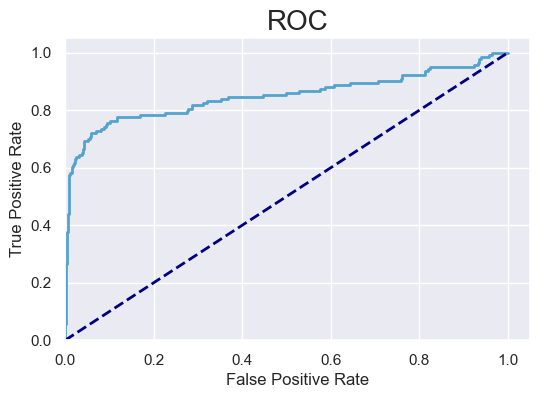

In [29]:
plt.figure()
# plot the FPR as X-axis and TPR as Y-axis
plt.plot(FPR, TPR)
# plot the minimum line 
plt.plot([0,1], [0,1], color='navy', linestyle = '--')
# set X and Y limits
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
# mention lables for X and Y
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')

## Gradient Boosting Regression Trees (or GBRT)

Another very popular Boosting algorithm is *Gradient Boosting*. Just like Adaboost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like *Adaboost*, this method tries to fit the new predecessor to the *residual errors* made by the previous predecessors.

Below is an example of *Gradient Boosting* for regression on a noisy quad dataset.

In [30]:
n_samples = 200

X_reg = 6 * np.random.rand(n_samples, 1) - 3
y_reg = 0.5 * X_reg**2 + 0.3 * X_reg + 2 + np.random.rand(n_samples,1)

Text(0.5, 1.0, 'Noisy dataset')

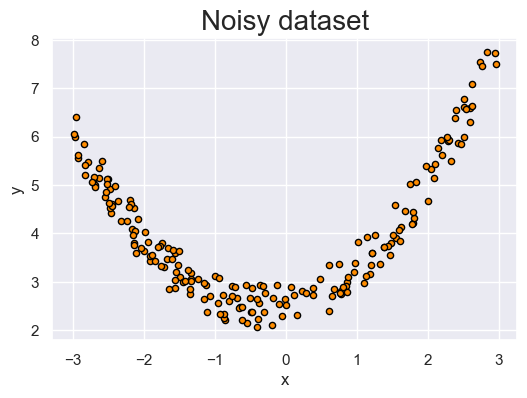

In [31]:
plt.scatter(X_reg, y_reg, c="darkorange", 
            edgecolor="black", label="data", s=20)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy dataset')

In [32]:
X_reg_train, X_reg_test = X_reg[:100], X_reg[100:]
y_reg_train, y_reg_test = y_reg[:100], y_reg[100:]

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

# gbrt - Gradient Boosted Regression Trees
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators = 100, learning_rate = 0.1)
gbrt.fit(X_reg_train,y_reg_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [34]:
from sklearn.metrics import mean_squared_error

X_reg_test = np.arange(-3.0,3.0,0.01)
y_reg_pred = gbrt.predict(X_reg_test[:,np.newaxis])

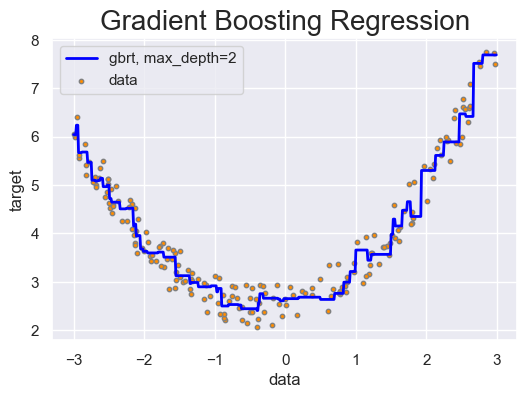

In [35]:
# Plot the results

plt.figure()
plt.scatter(X_reg, y_reg, c="darkorange", 
            edgecolor="grey", label="data", s=10)
plt.plot(X_reg_test, y_reg_pred, 
         c="blue",
         label="gbrt, max_depth=2", 
         )
plt.xlabel("data")
plt.ylabel("target")
plt.title("Gradient Boosting Regression")
plt.legend()

### Excercise

1. Try to train a deeper **Gradient Boosting Regression Tree (or GBRT)** and see how it fits the data.
2. Generate a cubic dataset (y = f(x) = a*x^3 + b*x^2 + c*x + d). Fit a GBRT to this data and plot the results.
3. Train other models, like KNN, SVM etc as the base estimator in `AdaBoostClassifer`. Which model do you think best fits the data ?

# XGBoost

Let us recap the concepts of *decision trees*, *bagging*, *adaptive boosting* and *gradient boosting* before diving into *Extreme Gradient Boosting* (or XGBoost).

Imagine that you are hiring manager for a company interviewing several candidates with different qualifications. Each step of the evolution of tree-based algorithms can be viewed as a version of the interview process.  [Source](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

1. **Decision Tree**: Each hiring manager has a set of criteria such as education level, number of years of experience, interview performance. A decision tree is analogous to a hiring manager interviewing candidates based on his or her own criteria.


2. **Bagging**: Imagine instead of a single interviewer, there is now an interview panel where each interviewer has a vote. *Bagging* or boostrap aggregation involves combining combining inputs from all interviewers for the final decision through a voting process.


3. **Random Forest**: Random Forests are a bagging-based algorithm with the key difference where only a subset of features are selected at random. In other words, an interviewer will only test the interviewee on certain selected qualifications.


4. **Boosting**: Boosting is an alternative approach where each interviewer alters the evaluation criteria based on feedback received from the previous interviewer. This *boosts* the efficieny of the interview process by deploying a more dynamic evaluation process.


5. **Gradient Boosting**: A special case of *Boosting* where the errors are minimized by gradient descent algorithm.


6. **XGBoost**: XGBoost is an enhanced version of gradient boosting, which yields superior results using less computing resources in the shortest amount of time.

Below are some optimizations XGBoost algorithm inherantly provides over vanilla *Gradient Boosting*.

1. **Regularization**: It penalizes more complex models through both L1 and L2 regularization to avoid overfitting.

2. **Sparsity Awareness**: XGBoost naturally admits sparse features for inputs by automatically *learning* best missing value depending on training loss and handles different types of sparsity patterns in the data more efficiently.

3. **Cross-validation**: The algorithm comes with built-in *cross-validation* method at each iteration, taking away the need to explicitly program this search and to specify the exact number of boosting iterations required in a single run.

To use XGBoost in python, you will have to install XGBoost library separately. Look at the [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/build.html#installation-gui) for installing XGBoost on Win, Linux and MacOS. 

## `XGBoostClassifier` on Churn dataset

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

try:
    from xgboost import XGBClassifier
except Exception as e:
    print(e) # xgboost module is not installed.

No module named 'py4j'


In [2]:
xgb = XGBClassifier(n_estimators=10)

NameError: name 'XGBClassifier' is not defined

In [38]:
%%time

xgb.fit(X_train, Y_train)

CPU times: user 156 ms, sys: 6.4 ms, total: 163 ms
Wall time: 28.5 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=10, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [39]:
Y_pred = xgb.predict(X_test)

In [40]:
test_acc_xgb = (Y_pred == Y_test).sum().astype(float)/len(Y_test)
print(f'Test accuracy: {test_acc_xgb:.2f}')

Test accuracy: 0.95


In [41]:
Y_train_pred = xgb.predict(X_train)
train_acc_xgb = (Y_train_pred == Y_train).sum().astype(float)/len(Y_train)
print(f'Train accuracy: {train_acc_xgb:.2f}')

Train accuracy: 0.97
